## ※ Business analytics tutorial- Anomaly detection
---
본 튜토리얼은 고려대학교 강필성 교수님의 Business analytics 수업의 내용을 정리한 튜토리얼 코드 입니다.  
튜토리얼에서는 Anomaly detection의 대표적인 방법론인 **Auto-Encoder** 에 대한 코드와 간단한 설명을 다룹니다.  
추가로 수업 시간에는 다루지 않은 내용이지만, time series anomaly detection 방법론으로 유명한 **USAD** 에 대한 코드와 내용도 다루고자 합니다. 또한 튜토리얼은 아래의 사이트의 내용을 참고하여 작성하였습니다.

출처1: https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/  

출처2: https://github.com/manigalati/usad  



In [1]:
#  필요 라이브러리 호출
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn


### PSM dataset을 활용한 Auto encoder 실습
본 실험에서는 가장 유명한 시계열 데이터셋 중 하나인  **PSM(Pooled Server Metric)** dataset을 활용하여 Auto encoder에 대한 실험을 진행하고자합니다. **PSM** dataset의 경우 eBay에서 제안한 데이터셋으로 application server node에서 수집한 26개의 차원으로 구성되어 있는 데이터셋 입니다.
**PSM** dataset은 train, test, test_label로 이뤄진 **시계열 데이터 이상치 탐지**를 위해 구성된 데이터셋입니다. Train data의 경우 모두 정상 데이터이고, test data에는 정상과 이상치가 섞여있으며 그에 대한 label을 test_label에 저장하고 있습니다. 
  
본 데이터셋을 활용하여 Auto Encoder의 anomaly detection 성능에 대한 실험을 진행하겠습니다.

In [2]:
# PSM datset load
train = pd.read_csv("dataset/PSM/train.csv")
test = pd.read_csv("dataset/PSM/test.csv")
test_label = pd.read_csv("dataset/PSM/test_label.csv")

In [3]:
# train dataset결측치 확인 -> 결측치가 전체의 3% 정도 이므로 결측치를 모두 제거한 dataset을 활용하여 실험을 진행

print(train.isnull().sum())
print((train.isnull().sum()).sum()/len(train))

timestamp_(min)       0
feature_0             0
feature_1             0
feature_2             0
feature_3             0
feature_4           202
feature_5           249
feature_6           563
feature_7            47
feature_8            47
feature_9             0
feature_10           47
feature_11            0
feature_12            0
feature_13          249
feature_14          202
feature_15            0
feature_16            0
feature_17            0
feature_18          202
feature_19            0
feature_20            0
feature_21         2136
feature_22          204
feature_23            0
feature_24           47
dtype: int64
0.031664917988239824


In [4]:
# test dataset결측치 확인 -> 결측치 없음
print(test.isnull().sum())


timestamp_(min)    0
feature_0          0
feature_1          0
feature_2          0
feature_3          0
feature_4          0
feature_5          0
feature_6          0
feature_7          0
feature_8          0
feature_9          0
feature_10         0
feature_11         0
feature_12         0
feature_13         0
feature_14         0
feature_15         0
feature_16         0
feature_17         0
feature_18         0
feature_19         0
feature_20         0
feature_21         0
feature_22         0
feature_23         0
feature_24         0
dtype: int64


In [5]:
# 결측치 제거
train = train.dropna()

In [6]:
print(train.isnull().sum())

timestamp_(min)    0
feature_0          0
feature_1          0
feature_2          0
feature_3          0
feature_4          0
feature_5          0
feature_6          0
feature_7          0
feature_8          0
feature_9          0
feature_10         0
feature_11         0
feature_12         0
feature_13         0
feature_14         0
feature_15         0
feature_16         0
feature_17         0
feature_18         0
feature_19         0
feature_20         0
feature_21         0
feature_22         0
feature_23         0
feature_24         0
dtype: int64


### Auto Encoder
Auto Encoder는 데이터를 원래의 차원보다 작은 latent dimmension에 mapping하고 다시 원래의 차원으로 원복하는 과정을 통해서 학습이 진행됩니다.   
기존의 데이터의 차원보다 더 작은 latent 차원에 mapping 된 데이터를 다시 원복하는 경우 기존의 data를 완벽하게 복원해낼 수는 없습니다.  
Auto Encoder의 경우 기존 데이터와 복원된 데이터의 차이를 최소화 하는 방향으로 학습이 진행됩니다. 이러한 Auto Encoder의 구조는 다음과 같습니다.  

<img src="images/images_jaehyeong_post_autoencoder-architecture.png" width="850px" height="396px" title="Auto encoder structure">  

<이미지 출처: https://velog.io/@jaehyeong/Autoencoder%EC%99%80-LSTM-Autoencoder>  

Auto Encoder를 처음 접한 사람은 데이터의 차원을 줄였다가 다시 원상 복귀 하는 것이 필요한지 의문이 들수도 있습니다.  
하지만 이러한 Auto Encoder를 활용하면 1) 차원 축소, 2) Anomaly detection 방법론으로 훌륭히 역할을 수행합니다.  

- Auto Encoder의 활용

    - 차원 축소      
    Auto Encoder를 통해 데이터의 차원을 축소할 수 있습니다. Latent space가 기존 data의 차원보다 더 작으므로 원래 차원으로 복원하는 과정을 거쳐도 기존 데이터보다는 작은 차원을 갖습니다.  
    따라서 Auto Encoder를 통해 기존 데이터의 정보를 최대한 보존하면서 차원 축소를 진행할 수 있습니다.  

    - Anomaly detection      
    Auto Encoder는 기존 데이터와 복원된 데이터의 차이를 줄이는 방향으로 학습이 전개됩니다. 이때 기존 데이터와 복원된 데이터의 차이를 재구축 오차(reconstruction error)라고 명명합니다.  
    잘 학습된 Auto Encoder를 사용한다고 가정하면, 정상 데이터의 경우 재구축 오차가 작을 것이고, 이상치 데이터는 Auto encoder의 학습에 많이 사용되지 않은 데이터 종류일 것 이므로 재구축 오차가 상대적으로 높을 것 입니다.  
    이렇게 데이터의 재구축 오차를 기준으로 정상 데이터와 이상치 데이터를 구분하는 방법론이 Auto encoder를 활용한 anomaly detection 방법론 입니다.  

본 실습에서는 이러한 Auto Encoder의 특성을 활용하여 Auto encoder를 활용한 time series data의 anomaly detection을 수행하고자 합니다.  


### Auto Encoder 설계
Input을 Latent dim 까지 점진적으로 줄여 나가는 auto encoder layer를 설계하였고, 학습에 사용하겠습니다.

In [7]:
# util 함수 작성

from sklearn.metrics import roc_curve,roc_auc_score

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    loss = [x['val_loss'] for x in history]
    plt.plot(loss, '-x', label="val_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs')
    plt.grid()
    plt.show()

def plot_history_USAD(history):
    losses1 = [x['val_loss1'] for x in history]
    losses2 = [x['val_loss2'] for x in history]
    plt.plot(losses1, '-x', label="loss1")
    plt.plot(losses2, '-x', label="loss2")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()
    
def histogram(y_test,y_pred):
    plt.figure(figsize=(12,6))
    plt.hist([y_pred[y_test==0],
              y_pred[y_test==1]],
            bins=20,
            color = ['#82E0AA','#EC7063'],stacked=True)
    plt.title("Results",size=20)
    plt.grid()
    plt.show()
    
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

In [181]:
# Encoder & Decoder module 설계
class Encoder(nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, int(in_size/2))
    self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
    self.linear3 = nn.Linear(int(in_size/4), latent_size)
    self.relu = nn.ReLU(True)
        
  def forward(self, w):
    out = self.linear1(w)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    z = self.relu(out)
    return z
    
class Decoder(nn.Module):
  def __init__(self, latent_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(latent_size, int(out_size/4))
    self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
    self.linear3 = nn.Linear(int(out_size/2), out_size)
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()
        
  def forward(self, z):
    out = self.linear1(z)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    w = self.sigmoid(out)
    return w

In [182]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AutoencoderModel(nn.Module):
  def __init__(self, w_size, z_size):
    super().__init__()
    self.encoder = Encoder(w_size, z_size)
    self.decoder = Decoder(z_size, w_size)
  
  def training_step(self, batch):
    criterion = nn.L1Loss(reduction='mean').to(device)
    z = self.encoder(batch)
    w = self.decoder(z)
    loss = criterion(w, batch)
    
    return loss

  def validation_step(self, batch, n):
    criterion = nn.L1Loss(reduction='mean').to(device)
    z = self.encoder(batch)
    w = self.decoder(z)
    loss = criterion(w, batch)
    return {'val_loss': loss}
        
  def validation_epoch_end(self, outputs):
    batch_loss = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    
    return {'val_loss': epoch_loss.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(list(model.encoder.parameters())+list(model.decoder.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            
            #Train AE
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        criterion = nn.L1Loss(reduction='none').to(device) # loss를 데이터 by 데이터로 계산
        z = model.encoder(batch)
        w = model.decoder(z)
        loss = criterion(w, batch)

        results.append(torch.mean(loss, axis =1))
    return results

In [8]:
# device 지정
device = get_default_device()


In [9]:
# train data 전처리
train = train.drop(['timestamp_(min)'], axis =1)

In [10]:
train.shape

(129784, 25)

In [11]:
# Min_max scaler를 통한 scaling
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = train.values
x_scaled = min_max_scaler.fit_transform(x)
train = pd.DataFrame(x_scaled)

In [12]:
# test data 전처리
test = test.drop(['timestamp_(min)'], axis =1)

In [13]:
# label(normal or anomaly) list

labels = [float(test_label["label"][i]) for i in range(len(test_label))]


In [14]:
x = test.values 
x_scaled = min_max_scaler.transform(x)
test = pd.DataFrame(x_scaled)

In [15]:
# train, test data window 구성
window_size=12
windows_train=train.values[np.arange(window_size)[None, :] + np.arange(train.shape[0]-window_size)[:, None]]
print(windows_train.shape)
windows_test=test.values[np.arange(window_size)[None, :] + np.arange(test.shape[0]-window_size)[:, None]]
print(windows_test.shape)

(129772, 12, 25)
(87829, 12, 25)


In [183]:
# 학습 시작

import torch.utils.data as data_utils

BATCH_SIZE =  377 # testset 크기의 약수
N_EPOCHS = 2000
hidden_size = 100

w_size=windows_train.shape[1]*windows_train.shape[2]
z_size=windows_train.shape[1]*hidden_size

windows_train = windows_train[:int(np.floor(.8 *  windows_train.shape[0]))]
windows_val = windows_train[int(np.floor(.8 *  windows_train.shape[0])):int(np.floor(windows_train.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_train).float().view(([windows_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_val).float().view(([windows_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_test).float().view(([windows_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = AutoencoderModel(w_size, z_size)
model = to_device(model,device)

In [102]:
# 100 epoch 학습
history = training(N_EPOCHS,model,train_loader,val_loader)


Epoch [0], val_loss: 0.0481
Epoch [1], val_loss: 0.0447
Epoch [2], val_loss: 0.0442
Epoch [3], val_loss: 0.0412
Epoch [4], val_loss: 0.0395
Epoch [5], val_loss: 0.0399
Epoch [6], val_loss: 0.0397
Epoch [7], val_loss: 0.0398
Epoch [8], val_loss: 0.0397
Epoch [9], val_loss: 0.0391
Epoch [10], val_loss: 0.0341
Epoch [11], val_loss: 0.0431
Epoch [12], val_loss: 0.0281
Epoch [13], val_loss: 0.0253
Epoch [14], val_loss: 0.0244
Epoch [15], val_loss: 0.0246
Epoch [16], val_loss: 0.0289
Epoch [17], val_loss: 0.0256
Epoch [18], val_loss: 0.0244
Epoch [19], val_loss: 0.0240
Epoch [20], val_loss: 0.0242
Epoch [21], val_loss: 0.0241
Epoch [22], val_loss: 0.0235
Epoch [23], val_loss: 0.0229
Epoch [24], val_loss: 0.0223
Epoch [25], val_loss: 0.0222
Epoch [26], val_loss: 0.0217
Epoch [27], val_loss: 0.0216
Epoch [28], val_loss: 0.0216
Epoch [29], val_loss: 0.0220
Epoch [30], val_loss: 0.0214
Epoch [31], val_loss: 0.0217
Epoch [32], val_loss: 0.0224
Epoch [33], val_loss: 0.0216
Epoch [34], val_loss: 0.

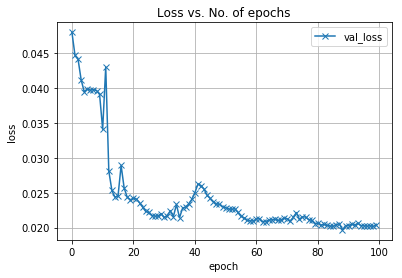

In [103]:
# 100 epoch까지 학습을 했을때도 validation loss가 감소하는 추세를 보이므로, 
# epoch을 500으로 늘려서 학습을 추가 진행
plot_history(history)

In [105]:
# 500 epoch 학습
history = training(N_EPOCHS,model,train_loader,val_loader)


Epoch [0], val_loss: 0.0482
Epoch [1], val_loss: 0.0421
Epoch [2], val_loss: 0.0417
Epoch [3], val_loss: 0.0404
Epoch [4], val_loss: 0.0384
Epoch [5], val_loss: 0.0381
Epoch [6], val_loss: 0.0369
Epoch [7], val_loss: 0.0374
Epoch [8], val_loss: 0.0367
Epoch [9], val_loss: 0.0371
Epoch [10], val_loss: 0.0357
Epoch [11], val_loss: 0.0374
Epoch [12], val_loss: 0.0303
Epoch [13], val_loss: 0.0301
Epoch [14], val_loss: 0.0309
Epoch [15], val_loss: 0.0246
Epoch [16], val_loss: 0.0323
Epoch [17], val_loss: 0.0264
Epoch [18], val_loss: 0.0300
Epoch [19], val_loss: 0.0271
Epoch [20], val_loss: 0.0273
Epoch [21], val_loss: 0.0266
Epoch [22], val_loss: 0.0259
Epoch [23], val_loss: 0.0241
Epoch [24], val_loss: 0.0220
Epoch [25], val_loss: 0.0214
Epoch [26], val_loss: 0.0211
Epoch [27], val_loss: 0.0207
Epoch [28], val_loss: 0.0213
Epoch [29], val_loss: 0.0204
Epoch [30], val_loss: 0.0208
Epoch [31], val_loss: 0.0205
Epoch [32], val_loss: 0.0206
Epoch [33], val_loss: 0.0205
Epoch [34], val_loss: 0.

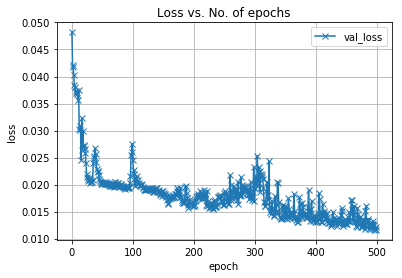

In [106]:
# 500 epoch 학습 결과 -> loss가 어느정도 수렴하는 추세를 보이지만, 
# 추가적인 학습이 필요하다고 예상되어 2000 epoch으로 늘려서 추가 학습 진행
plot_history(history)

In [184]:
# 2000 epoch 학습
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss: 0.0548
Epoch [1], val_loss: 0.0502
Epoch [2], val_loss: 0.0498
Epoch [3], val_loss: 0.0489
Epoch [4], val_loss: 0.0560
Epoch [5], val_loss: 0.0393
Epoch [6], val_loss: 0.0421
Epoch [7], val_loss: 0.0361
Epoch [8], val_loss: 0.0452
Epoch [9], val_loss: 0.0352
Epoch [10], val_loss: 0.0451
Epoch [11], val_loss: 0.0444
Epoch [12], val_loss: 0.0364
Epoch [13], val_loss: 0.0398
Epoch [14], val_loss: 0.0394
Epoch [15], val_loss: 0.0371
Epoch [16], val_loss: 0.0304
Epoch [17], val_loss: 0.0405
Epoch [18], val_loss: 0.0359
Epoch [19], val_loss: 0.0348
Epoch [20], val_loss: 0.0356
Epoch [21], val_loss: 0.0342
Epoch [22], val_loss: 0.0343
Epoch [23], val_loss: 0.0307
Epoch [24], val_loss: 0.0338
Epoch [25], val_loss: 0.0330
Epoch [26], val_loss: 0.0332
Epoch [27], val_loss: 0.0333
Epoch [28], val_loss: 0.0333
Epoch [29], val_loss: 0.0322
Epoch [30], val_loss: 0.0341
Epoch [31], val_loss: 0.0334
Epoch [32], val_loss: 0.0315
Epoch [33], val_loss: 0.0326
Epoch [34], val_loss: 0.

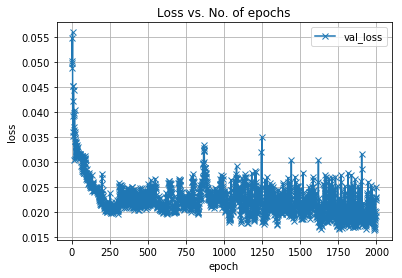

In [185]:
# 2000 epoch 학습 결과 -> loss가 수렴하는 경향을 보여 학습 종료
plot_history(history)

In [186]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder': model.decoder.state_dict(),
            }, "model.pth")

### Test
2000 epoch을 학습한 model의 check point를 통해 test를 시작

In [187]:
results=testing(model,test_loader)

In [191]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [33]:
y_test =[label for label in test_label['label']]

In [39]:
# Time window에서 짤리는 부분은 drop하여 pred와 길이를 맞춰줌
y_test = y_test[:len(y_pred)]

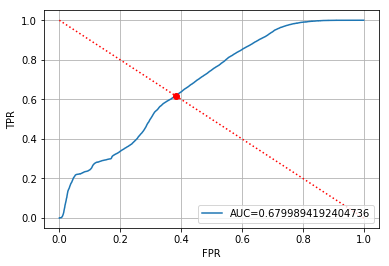

In [192]:
threshold=ROC(y_test,y_pred)

In [196]:
threshold = threshold.item()

In [42]:
# threshold 기반 anomaly 예측
def prediction(y_pred, threshold):
    y_pred_class = []
    for value in y_pred:
        if value > threshold:
            y_pred_class.append(1)
        
        else:
            y_pred_class.append(0)
    return y_pred_class

In [ ]:
y_anomaly_pred = prediction(y_pred, threshold)
# confusion matrix
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_anomaly_pred).ravel()

acc = (tp + tn)/(tn + fp + fn + tp)

In [201]:
y_anomaly_pred = prediction(y_pred, threshold)

In [221]:
print(f"{'-' * 48}result{'-' * 48}")
print(f'Accuracy: {round(acc, 2)} True negative: {tn}, False positive:{fp}, False negative:{fn}, True positive: {tp}\n')
print(f"{'-' * 43}Confusion matrix{'-' * 43}")
confusion_matrix(y_test, y_anomaly_pred)

------------------------------------------------result------------------------------------------------
Accuracy: 0.62 True negative: 38705, False positive:24003, False negative:9617, True positive: 15504

-------------------------------------------Confusion matrix-------------------------------------------


array([[38705, 24003],
       [ 9617, 15504]])

### 실험결과

2000 Epoch을 기준으로 ROC curve를 그렸을때 AUC 값은 0.68, Acc는 0.62 정도의 값을 달성하였습니다.  
Anomaly detection이 쉽지 않은 task임을 감안하였을때 어느정도 우수한 성능을 도출했다고 판단됩니다.  
Max epoch, Auto encoder layer 수, Auto encoder bottle neck dimension 등의 하이퍼파라미터 서치를 통해 조금 더 결과가 우수한 모델을 산출 할 수 있을 것이라 예상됩니다. 

### USAD: UnSupervised Anomaly Detection on Multivariate Time Series
USAD(UnSupervised Anomaly Detection on Multivariate Time Series) 방법론은 autoencdoer와 GAN을 종합한 time series anomaly detection 방법론 입니다.  
USAD는 2개의 auto encoder로 구성됩니다. 첫번째 Autoencoder는 GAN에서의 generator 혁할을 2번째 Autoencoder는 GAN의 discriminator 역할을 수행합니다.  
즉 2개의 Autoencoder가 상호보완적으로 학습이 진행됩니다.  
이러한 USAD의 model 구조를 살펴보면 다음과 같습니다.  

<img src="images/usad_structure.png" width="819px" height="300px" title="usad structure">

이러한 USAD는 2-phase를 통해 학습되며 각각의 phase는 다음과 같습니다.  

- USAD 2-phase

    - Phase 1: Autoencoder training      
    일반적인 Autoencoder의 training 방식과 동일합니다.  
    본 모델 구조에서는 2개의 Autoencoder가 사용되므로 각각의 autoencoder를 모두 학습합니다.

    - Phase 2: Adversarial training    
    GAN의 구조와 동일하게 학습이 됩니다. Phase 1에서 학습한 2개의 encoder를 통해 1개는 generatoer, 1개는 discriminator의 역할을 하며 학습이 진행됩니다.  

한편 USAD는 안정적인 학습을 위해 loss function을 재구성하였습니다.  
학습 초반에는 reconstruction에 가중치를 주고, 후반에는 adversarial에 가중치를 주는 방향으로 loss를 구성하였습니다.  
Loss의 식은 다음과 같습니다.  


<img src="images/usad_loss.png" width="819px" height="207px" title="usad loss">

USAD를 통해 위의 autoencoder에서 사용했던 데이터셋인 PSM 데이터셋을 통해 anomaly detection 성능을 산출해보겠습니다.



In [16]:
# USAD model 설계

import torch
import torch.nn as nn

device = get_default_device()

class Encoder(nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.linear1 = nn.Linear(in_size, int(in_size/2))
    self.linear2 = nn.Linear(int(in_size/2), int(in_size/4))
    self.linear3 = nn.Linear(int(in_size/4), latent_size)
    self.relu = nn.ReLU(True)
        
  def forward(self, w):
    out = self.linear1(w)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    z = self.relu(out)
    return z
    
class Decoder(nn.Module):
  def __init__(self, latent_size, out_size):
    super().__init__()
    self.linear1 = nn.Linear(latent_size, int(out_size/4))
    self.linear2 = nn.Linear(int(out_size/4), int(out_size/2))
    self.linear3 = nn.Linear(int(out_size/2), out_size)
    self.relu = nn.ReLU(True)
    self.sigmoid = nn.Sigmoid()
        
  def forward(self, z):
    out = self.linear1(z)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu(out)
    out = self.linear3(out)
    w = self.sigmoid(out)
    return w
    
class UsadModel(nn.Module):
  def __init__(self, w_size, z_size):
    super().__init__()
    self.encoder = Encoder(w_size, z_size)
    self.decoder1 = Decoder(z_size, w_size)
    self.decoder2 = Decoder(z_size, w_size)
  
  def training_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return loss1,loss2

  def validation_step(self, batch, n):
    z = self.encoder(batch)
    w1 = self.decoder1(z)
    w2 = self.decoder2(z)
    w3 = self.decoder2(self.encoder(w1))
    loss1 = 1/n*torch.mean((batch-w1)**2)+(1-1/n)*torch.mean((batch-w3)**2)
    loss2 = 1/n*torch.mean((batch-w2)**2)-(1-1/n)*torch.mean((batch-w3)**2)
    return {'val_loss1': loss1, 'val_loss2': loss2}
        
  def validation_epoch_end(self, outputs):
    batch_losses1 = [x['val_loss1'] for x in outputs]
    epoch_loss1 = torch.stack(batch_losses1).mean()
    batch_losses2 = [x['val_loss2'] for x in outputs]
    epoch_loss2 = torch.stack(batch_losses2).mean()
    return {'val_loss1': epoch_loss1.item(), 'val_loss2': epoch_loss2.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))
    
def evaluate(model, val_loader, n):
    outputs = [model.validation_step(to_device(batch,device), n) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer1 = opt_func(list(model.encoder.parameters())+list(model.decoder1.parameters()))
    optimizer2 = opt_func(list(model.encoder.parameters())+list(model.decoder2.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch=to_device(batch,device)
            
            #Train AE1
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss1.backward()
            optimizer1.step()
            optimizer1.zero_grad()
            
            
            #Train AE2
            loss1,loss2 = model.training_step(batch,epoch+1)
            loss2.backward()
            optimizer2.step()
            optimizer2.zero_grad()
            
            
        result = evaluate(model, val_loader, epoch+1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
    
def testing(model, test_loader, alpha=.5, beta=.5):
    results=[]
    for [batch] in test_loader:
        batch=to_device(batch,device)
        w1=model.decoder1(model.encoder(batch))
        w2=model.decoder2(model.encoder(w1))
        results.append(alpha*torch.mean((batch-w1)**2,axis=1)+beta*torch.mean((batch-w2)**2,axis=1))
    return results

In [18]:
# windows dataset은 auto encoder와 동일하게 사용 
# Training

import torch.utils.data as data_utils

BATCH_SIZE =  377 # testset 크기의 약수
N_EPOCHS = 500
hidden_size = 100

w_size=windows_train.shape[1]*windows_train.shape[2]
z_size=windows_train.shape[1]*hidden_size

windows_train = windows_train[:int(np.floor(.8 *  windows_train.shape[0]))]
windows_val = windows_train[int(np.floor(.8 *  windows_train.shape[0])):int(np.floor(windows_train.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_train).float().view(([windows_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_val).float().view(([windows_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_test).float().view(([windows_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

usad = UsadModel(w_size, z_size)
usad = to_device(usad,device)

In [165]:
# 100 epoch 학습
history = training(N_EPOCHS,model,train_loader,val_loader)


Epoch [0], val_loss1: 0.0048, val_loss2: 0.0055
Epoch [1], val_loss1: 0.0065, val_loss2: -0.0020
Epoch [2], val_loss1: 0.0080, val_loss2: -0.0043
Epoch [3], val_loss1: 0.0066, val_loss2: -0.0042
Epoch [4], val_loss1: 0.0076, val_loss2: -0.0056
Epoch [5], val_loss1: 0.0068, val_loss2: -0.0052
Epoch [6], val_loss1: 0.0075, val_loss2: -0.0063
Epoch [7], val_loss1: 0.0077, val_loss2: -0.0064
Epoch [8], val_loss1: 0.0076, val_loss2: -0.0067
Epoch [9], val_loss1: 0.0076, val_loss2: -0.0066
Epoch [10], val_loss1: 0.0077, val_loss2: -0.0070
Epoch [11], val_loss1: 0.0076, val_loss2: -0.0070
Epoch [12], val_loss1: 0.0078, val_loss2: -0.0072
Epoch [13], val_loss1: 0.0099, val_loss2: -0.0090
Epoch [14], val_loss1: 0.0082, val_loss2: -0.0070
Epoch [15], val_loss1: 0.0077, val_loss2: -0.0069
Epoch [16], val_loss1: 0.0076, val_loss2: -0.0068
Epoch [17], val_loss1: 0.0074, val_loss2: -0.0066
Epoch [18], val_loss1: 0.0071, val_loss2: -0.0064
Epoch [19], val_loss1: 0.0074, val_loss2: -0.0067
Epoch [20],

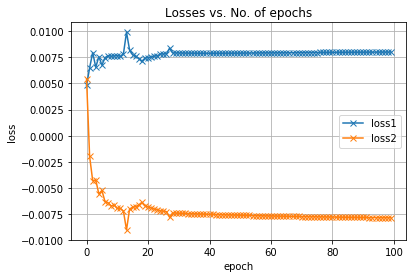

In [166]:
# 어느정도 수렴하는 경향성은 보이나 추가적인 학습이 필요하다고 판단하며 
# 500 epoch으로 epoch 수정 후 추가 실험
plot_history_USAD(history)


In [20]:
# 500 epoch 학습
history = training(N_EPOCHS,usad,train_loader,val_loader)

Epoch [0], val_loss1: 0.0067, val_loss2: 0.0068
Epoch [1], val_loss1: 0.0066, val_loss2: -0.0006
Epoch [2], val_loss1: 0.0077, val_loss2: -0.0032
Epoch [3], val_loss1: 0.0064, val_loss2: -0.0034
Epoch [4], val_loss1: 0.0064, val_loss2: -0.0040
Epoch [5], val_loss1: 0.0062, val_loss2: -0.0043
Epoch [6], val_loss1: 0.0067, val_loss2: -0.0049
Epoch [7], val_loss1: 0.0064, val_loss2: -0.0049
Epoch [8], val_loss1: 0.0065, val_loss2: -0.0052
Epoch [9], val_loss1: 0.0070, val_loss2: -0.0056
Epoch [10], val_loss1: 0.0066, val_loss2: -0.0054
Epoch [11], val_loss1: 0.0067, val_loss2: -0.0056
Epoch [12], val_loss1: 0.0069, val_loss2: -0.0059
Epoch [13], val_loss1: 0.0067, val_loss2: -0.0058
Epoch [14], val_loss1: 0.0070, val_loss2: -0.0061
Epoch [15], val_loss1: 0.0068, val_loss2: -0.0060
Epoch [16], val_loss1: 0.0060, val_loss2: -0.0053
Epoch [17], val_loss1: 0.0064, val_loss2: -0.0058
Epoch [18], val_loss1: 0.0060, val_loss2: -0.0054
Epoch [19], val_loss1: 0.0065, val_loss2: -0.0059
Epoch [20],

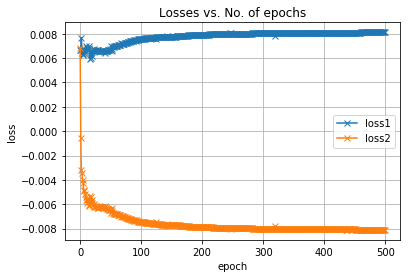

In [21]:
# 500 epoch으로 최종 학습 종료

plot_history_USAD(history)

In [23]:
torch.save({
            'encoder': usad.encoder.state_dict(),
            'decoder1': usad.decoder1.state_dict(),
            'decoder2': usad.decoder2.state_dict()
            }, "usad.pth")

In [24]:
results=testing(usad,test_loader)

In [25]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

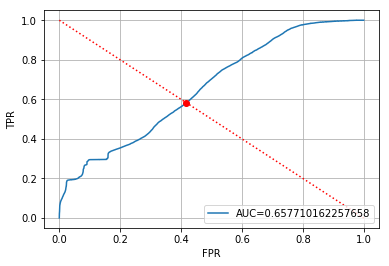

In [40]:
threshold=ROC(y_test,y_pred)

In [174]:
threshold

array([0.0069347], dtype=float32)

In [43]:
y_anomaly_pred = prediction(y_pred, threshold)

In [44]:
# confusion matrix
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_anomaly_pred).ravel()

acc = (tp + tn)/(tn + fp + fn + tp)

print(f"{'-' * 48}result{'-' * 48}")
print(f'Accuracy: {round(acc, 2)} True negative: {tn}, False positive:{fp}, False negative:{fn}, True positive: {tp}\n')
print(f"{'-' * 43}Confusion matrix{'-' * 43}")
confusion_matrix(y_test, y_anomaly_pred)

------------------------------------------------result------------------------------------------------
Accuracy: 0.58 True negative: 36951, False positive:26503, False negative:10182, True positive: 14193

-------------------------------------------Confusion matrix-------------------------------------------


array([[36951, 26503],
       [10182, 14193]])

### 실험결과

500 Epoch을 기준으로 ROC curve를 그렸을때 AUC 값이 0.66, Acc는 0.58정도로 산출되었습니다.  
Auto Encoder보다 advanced 된 모델이지만 성능은 오히려 더 하락하였습니다.  
항상 고도화된 방법론이라고 모든 데이터셋에 대해 좋은 성능을 나타내는 것은 아님을 보여주었습니다.  
하지만, 추가적인 하이퍼파라미터 서치를 통해 충분히 모델의 성능을 상승 시킬 수 있을 것이라 판단합니다.  
좀 더 높은 성능 도출을 위해 USAD 내부의 Auto Encoder의 dimension 변경 전략을 바꿀 수도 있고, latent dimension의 크기를 조절할 수도 있을 것 입니다.  

Auto Encoder, USAD를 통해 time series data의 Anomaly detection을 수행하였습니다.  
밀도 기반의 모델을 통하여 실험을 해보는 것도 좋은 튜토리얼 주제가 될 것이라 예상됩니다.